In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
import matplotlib.scale as mscale
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps
H_to_K = 1/0.000003166808534191

In [94]:
C12 = 3.05e8 #C12 coefficient in Eh*ao
C6 = 4710 #C6 coefficient in Eh*ao
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb)

# $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 8.55\times10^{7} E_{h}a_{0}$, $C_{6} = 6710 E_{h}a_{0}$

-0.018183674629667836


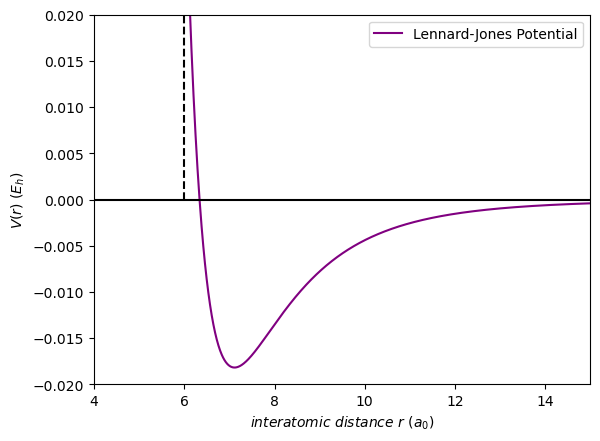

In [4]:
Npts = 7500
r = np.linspace(4,60, Npts) # range of r values to iterate over, 4 -> 60 Bohr radii
#r_pot = np.linspace(4,60, N) # range of r values to iterate over, ~0 -> 60 Bohr radii
psi = np.zeros(Npts)

Vr = (C12/(r**12)) - (C6/(r**6))



plt.plot(r, Vr, label = 'Lennard-Jones Potential', color = 'purple')
plt.hlines(0,0, max(r), color = 'black')
plt.vlines(6, 0, max(r), color = 'black', linestyle = 'dashed')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{0})$')
plt.ylabel('$V(r)$ $(E_{h})$')
plt.ylim(-0.02, 0.02)
plt.xlim(4,15)
plt.legend()

print(min(Vr))
#plt.vlines(6.375,-0.02,0.02)
#plt.vlines(11.04,-0.02,0.02)

# LJ DVR

## $ x \in (a,b) $, $x_{i} = a + \frac{(b-a)i}{N}, i = 1,2,..,N-1$, $dx = \frac{(b-a)}{N}$
# $ T_{ij} = \frac{1}{2} \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{2} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $
# $ T_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}]$
# $ V_{ii} = \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6}$

# $H_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4 \mu} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}] + \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6} $
# $ H_{ij} = \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{4\mu} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $

In [64]:
def Hamiltonian_DVR(a, b, dx):
    N = int((b-a)/dx) # Number of grid points
   # print(f' N = {N}')
    x = np.linspace(a + dx,b - dx, N - 1) # grid

    Vx = C12/(x**12) - C6/(x**6)
    Vxmin = abs(min(VLJ))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N x N

    for i in range(1, N):
        for j in range(1, N):
            if i == j: # fill in diagonal components of the Hamiltonian
                prefacii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                Vii = (C12/(x[i - 1]**12)) - (C6/(x[i - 1]**6))
                
                H_DVR[i - 1][j - 1] = prefacii*bracketii + Vii
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                prefacij = (-1**(i-j))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((i-j)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                
                H_DVR[i - 1][j - 1] = prefacij*bracketij
                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))

    return H_DVR

In [66]:
a1 = 4.5
b1 = 80
dx1 = 0.05

N1 = int((b1-a1)/dx1) # Number of grid points
x1 = np.linspace(a1 + dx1,b1 - dx1, N1-1)
VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

In [90]:
tol = 1e-6

Heig = np.linalg.eigh(H)[0]
print(Heig[303:315])


Eigvec = np.linalg.eigh(H)[1]
Hvec = []

for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)

for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

for i in range(len(Hvec)):
    Norm = np.trapz(np.abs(Hvec[i])**2,x1)
    assert( abs(Norm - 1) < tol)

print(np.trapz(np.abs(Hvec[0])**2,x1))

#for i in range(len(Hvec)):
   # Hvec[i] = np.abs(Hvec[i])**2


[-2.30206225e-05 -2.06481436e-05  6.71442668e-06  3.40602099e-05
  6.13888614e-05  8.87002710e-05  1.15994337e-04  1.43270961e-04
  1.70530050e-04  1.97771514e-04  2.24995267e-04  2.52201225e-04]
1.0


In [68]:
tol = 1e-6

small_diff = []

for i in range(len(H[0])):
    Hnvecn = np.matmul(H, Hvec[i])
    Envecn = Heig[i]*Hvec[i]
    diff  = np.abs(Hnvecn - Envecn)
    max_diff = max(diff)
    if max_diff < tol:
        small_diff.append(i)

In [69]:
print(len(small_diff))

1509


In [70]:
Hneg = Heig[Heig > Vmin]

Hwell = Hneg[Hneg < 0]

print(len(Hwell))

#print(Hwell[0:10] - Heig[0:10])

wellvec = []

for i in range(len(Hwell)):
    for j in range(len(Heig)):
        if Hwell[i] == Heig[j]:
            wellvec.append(Hvec[i])

print(len(wellvec))

301
301


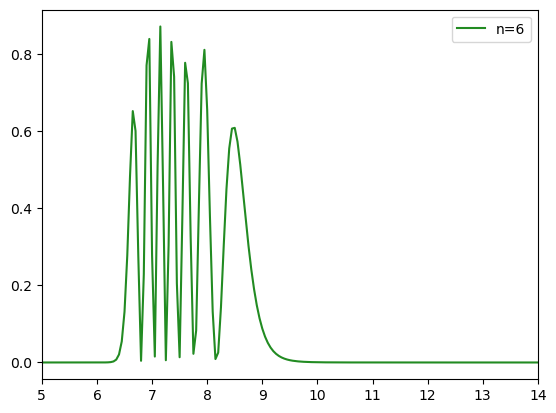

In [35]:
for i in range(len(Hvec)):
    if i == 6:
        plt.plot(x1, np.abs(Hvec[i])**2, color = 'forestgreen', label = f'n={i}')

plt.xlim(5,14)
plt.legend()

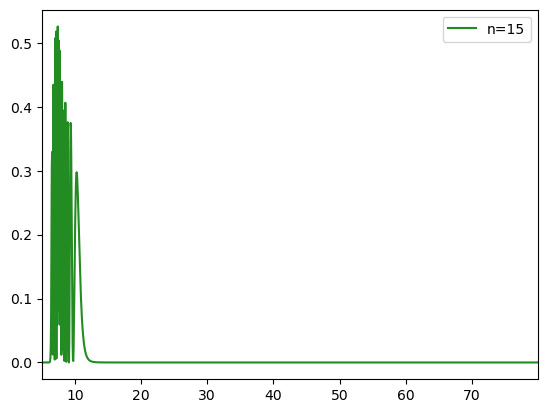

In [36]:
for i in range(len(Hvec)):
    if i == 15:
        plt.plot(x1, np.abs(Hvec[i])**2, color = 'forestgreen', label = f'n={i}')

plt.xlim(5,max(x1))
plt.legend()

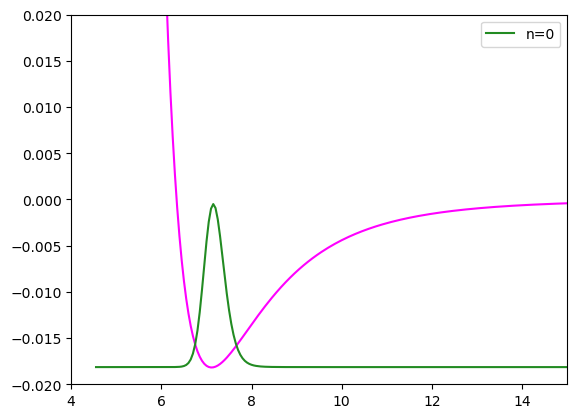

In [37]:

plt.plot(x1, VLJ, color = 'fuchsia')
for i in range(len(Hvec)):
    if i == 0:
        plt.plot(x1, 0.01*np.abs(Hvec[i])**2 + Hwell[i], color = 'forestgreen', label = f'n={i}')


plt.ylim(-0.02, 0.02)
plt.xlim(4,15)
plt.legend()

In [48]:
np.set_printoptions(threshold=np.inf)
Hneg = Heig[Heig > Vmin]

Hwell = Hneg[Hneg < 0]

#print(len(Hwell))

#print(Hwell[0:10] - Heig[0:10])

wellvec = []

for i in range(len(Hwell)):
    for j in range(len(Heig)):
        if Hwell[i] == Heig[j]:
            wellvec.append(Hvec[i])

#print(f' Well eigvals = {Hwell[0:10]}')

print(Vmin)
#print(f' Eigvals = {Heig}')

#print(f' Vmin = {Vmin}Eh')

#print(Heig[-1])

for i in range(len(Heig)):
    if Heig[i] == Hwell[0]:
        print(i)
        break


print(Vmin - Heig[0])

-0.01818148114033916
4
0.006434703845769465


In [20]:
iuqchn983c3r 

NameError: name 'iuqchn983c3r' is not defined

In [17]:
#b_range = np.linspace(14, 500, 20)

En = [ [] for i in range(51) ]

for i in range(len(b_range)):
    Hb = Hamiltonian_DVR(a1 + dx1, b_range[i] - dx1, dx1)
    Hbeig = np.linalg.eigh(Hb)[0]
    Es = Hbeig[0:51]
    for j in range(51):
        En[i].append(Es[j])
    if i == int(len(b_range)/2):
        print('halfway there')
    if i == int(8*(len(b_range)/9)):
        print('almost there')

KeyboardInterrupt: 

In [ ]:
print(En)

In [ ]:
for i in range(len(En)):
    if i == 18:
        if len(En[i]) != 0:
            plt.plot(b_range, En[i][0:len(b_range)], label = f'n={i}', color = 'goldenrod')

plt.legend()

In [126]:
def Hamiltonian_DVR(a, b, dx):
    N = int((b-a)/dx) # Number of grid points
    print(f' N = {N}')
    x = np.linspace(a + dx,b - dx, N - 1) # grid

    #Vx = C12/(x**12) - C6/(x**6)
    #Vxmin = abs(min(VLJ))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N x N

    for i in range(1, N):
        for j in range(1, N):
            if i == j: # fill in diagonal components of the Hamiltonian
                prefacii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                Vii = 102*(4343/(x[i - 1]**12) - 650/(x[i - 1]**6)) + 33/(x[i - 1]**2)
                
                H_DVR[i - 1][j - 1] = prefacii*bracketii + Vii
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                prefacij = (-1**(i-j))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((i-j)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                
                H_DVR[i - 1][j - 1] = prefacij*bracketij
                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))

    return H_DVR




-2466.8065544840997


(-2500.0, 100.0)

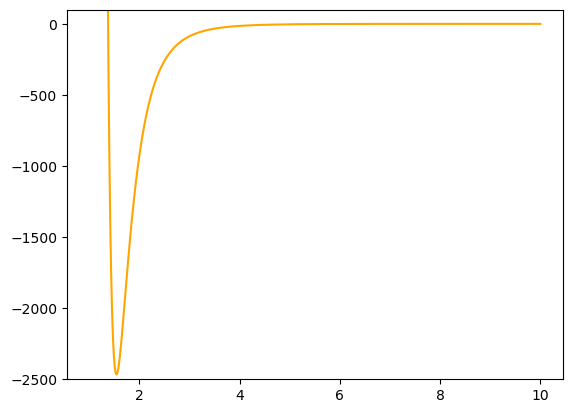

In [128]:
y = np.linspace(1,10,500)
Wcc = 102*(4343/(y**12) - 650/(y**6)) + 33/(y**2)

plt.plot(y, Wcc, color = 'orange')
print(min(Wcc))


plt.ylim(-2500,100)

In [154]:
dx2 = 0.001
a2 = 1
b2 = 10
H2 = Hamiltonian_DVR(a2,b2,dx2)

 N = 9000


In [ ]:
H2eig = np.linalg.eigh(H2)[0]


In [ ]:
print(H2eig[0])